In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [2]:
df = pd.read_csv('GL_2_merged.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'title', 'author', 'year', 'publication_year',
       'description', 'Genre', 'Author_Rating', 'total_weeks', 'best_rank',
       'worst_rank', 'mean_rank', 'debut_rank', 'average_rating',
       'ratings_count', 'rating', 'review_text', 'n_votes', 'is_expert',
       'Units_Sold', 'Gross_Sales', 'Sale_Price', 'Sales_Rank',
       'Duyet_Commercial_Success', 'Khang_Commercial_Success',
       'Kiet_Commercial_Success', 'Duyet_Popular_Success',
       'Khang_Popular_Success', 'Kiet_Popular_Success',
       'Duyet_Critical_Success', 'Khang_Critical_Success',
       'Kiet_Critical_Success'],
      dtype='object')

In [4]:
df.head()

,Unnamed: 0,title,author,year,publication_year,description,Genre,Author_Rating,total_weeks,best_rank,...,Sales_Rank,Duyet_Commercial_Success,Khang_Commercial_Success,Kiet_Commercial_Success,Duyet_Popular_Success,Khang_Popular_Success,Kiet_Popular_Success,Duyet_Critical_Success,Khang_Critical_Success,Kiet_Critical_Success
0,1389,A Crown Of Swords,Robert Jordan,1996,2013,"The Wheel of Time, Robert Jordan's internation...",Nonfiction,Intermediate,8,2,...,661,5,5,5,3,3,3,4,4,4
1,1475,A Crown Of Swords,Robert Jordan,1996,2013,"The Wheel of Time, Robert Jordan's internation...",Nonfiction,Intermediate,8,2,...,661,5,5,5,3,3,3,4,4,4
2,1337,A Dirty Job,Christopher Moore,2006,2007,Charlie Asher is a pretty normal guy with a no...,Nonfiction,Excellent,5,9,...,707,5,5,5,1,1,1,5,5,5
3,910,Bet Me,Jennifer Crusie,2004,2004,Minerva Dobbs knows that happily-ever-after is...,Fiction,Intermediate,3,9,...,1266,1,1,2,2,2,2,3,3,3
4,816,"Bud, Not Buddy",Christopher Paul Curtis,2000,2002,"It's 1936, in Flint, Michigan. Times may be ha...",Fiction,Intermediate,1,15,...,980,3,3,3,1,1,1,4,4,4


In [5]:
df = df.rename(columns={
    'Duyet_Commercial_Success': 'Duyet_Commercial',
    'Duyet_Popular_Success': 'Duyet_Public',
    'Duyet_Critical_Success': 'Duyet_Critical',
    'Khang_Commercial_Success': 'Khang_Commercial',
    'Khang_Popular_Success': 'Khang_Public',
    'Khang_Critical_Success': 'Khang_Critical',
    'Kiet_Commercial_Success': 'Kiet_Commercial',
    'Kiet_Popular_Success': 'Kiet_Public',
    'Kiet_Critical_Success': 'Kiet_Critical'
})

In [6]:
annotators = ['Duyet', 'Khang', 'Kiet']
fields = ['Commercial', 'Public', 'Critical']  
choices = ['1', '2', '3', '4', '5']

In [7]:
def fleiss_kappa(M):
    N, k = M.shape
    n_annotators = np.sum(M[0])
    P = np.sum(M, axis=0) / (N * n_annotators)
    P_i = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
    P_bar = np.mean(P_i)
    P_e = np.sum(P * P)
    kappa = (P_bar - P_e) / (1 - P_e) if (1 - P_e) != 0 else np.nan
    return kappa

In [8]:
kappa_results = {}
for field in fields:
    cols = [f'{ann}_{field}' for ann in annotators]
    
    # Bảng tổng hợp annotator x choice
    rows = []
    for col in cols:
        counts = {c: 0 for c in choices}
        for val in df[col].dropna().astype(str):
            if val in choices:
                counts[val] += 1
        rows.append([counts[c] for c in choices])
    
    df_table = pd.DataFrame(rows, columns=choices, index=annotators)
    df_table.index.name = 'Annotator'
    print(f'Bảng tổng hợp cho trường: {field} Success')
    display(df_table)
    
    # Ma trận cho Fleiss: mỗi dòng là 1 item, mỗi cột là count choice
    M = np.zeros((len(df), len(choices)), dtype=int)
    for i in range(len(df)):
        for j, col in enumerate(cols):
            val = str(df.at[i, col])
            if val in choices:
                idx = choices.index(val)
                M[i, idx] += 1
    
    kappa = fleiss_kappa(M)
    kappa_results[field] = kappa
    print(f"Fleiss' kappa cho trường {field} Success: {kappa:.4f}\n")


Bảng tổng hợp cho trường: Commercial Success


,1,2,3,4,5
Annotator,,,,,
Duyet,17,6,10,9,8
Khang,14,6,10,11,9
Kiet,7,10,11,12,10


Fleiss' kappa cho trường Commercial Success: 0.6388

Bảng tổng hợp cho trường: Public Success


,1,2,3,4,5
Annotator,,,,,
Duyet,11,9,13,11,6
Khang,10,11,12,10,7
Kiet,8,12,13,7,10


Fleiss' kappa cho trường Public Success: 0.8322

Bảng tổng hợp cho trường: Critical Success


,1,2,3,4,5
Annotator,,,,,
Duyet,3,18,6,7,16
Khang,3,9,6,14,18
Kiet,2,2,2,24,20


Fleiss' kappa cho trường Critical Success: 0.5716



In [9]:
kappa_df = pd.DataFrame.from_dict(kappa_results, orient='index', columns=["Fleiss' kappa"])
kappa_df.index = [f'{f} Success' for f in kappa_results]
display(kappa_df)


,Fleiss' kappa
Commercial Success,0.638817
Public Success,0.832196
Critical Success,0.571637


--- Phân tích trường: Commercial Success ---


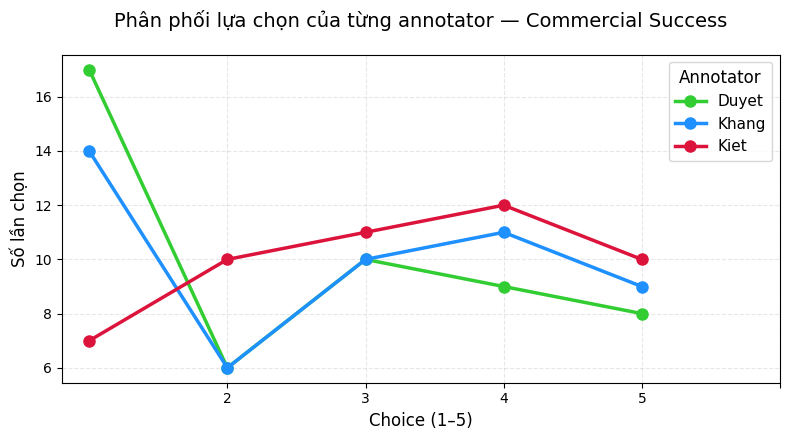

Số item bất đồng hoàn toàn (cả 3 chọn khác nhau): 1 / 50
   Ví dụ index: [36]
Tỉ lệ đồng thuận giữa các cặp annotator:
   Duyet vs Khang: 38/50 = 76.00%
   Duyet vs Kiet: 32/50 = 64.00%
   Khang vs Kiet: 37/50 = 74.00%


--- Phân tích trường: Public Success ---


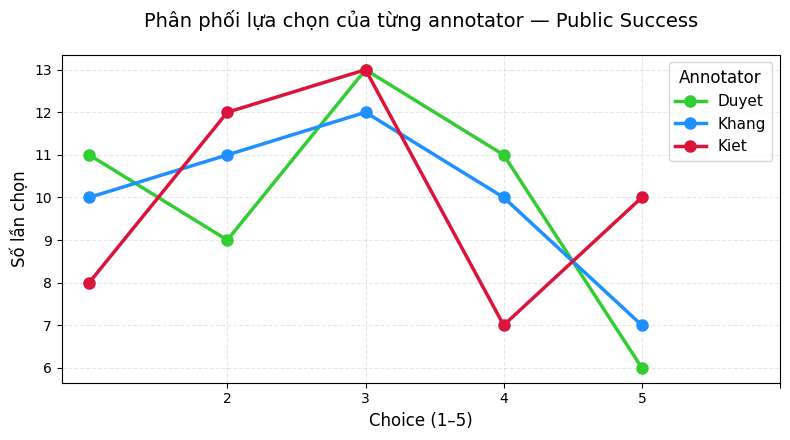

Số item bất đồng hoàn toàn (cả 3 chọn khác nhau): 0 / 50
Tỉ lệ đồng thuận giữa các cặp annotator:
   Duyet vs Khang: 43/50 = 86.00%
   Duyet vs Kiet: 43/50 = 86.00%
   Khang vs Kiet: 44/50 = 88.00%


--- Phân tích trường: Critical Success ---


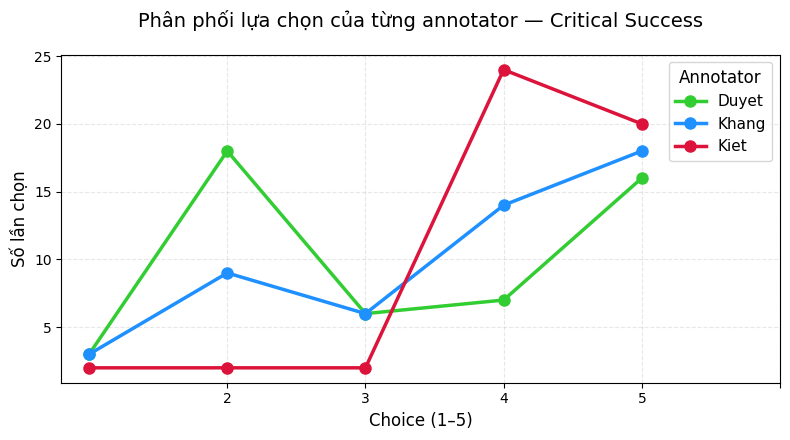

Số item bất đồng hoàn toàn (cả 3 chọn khác nhau): 3 / 50
   Ví dụ index: [11, 22, 23]
Tỉ lệ đồng thuận giữa các cặp annotator:
   Duyet vs Khang: 38/50 = 76.00%
   Duyet vs Kiet: 28/50 = 56.00%
   Khang vs Kiet: 37/50 = 74.00%




In [10]:
# EDA: Phân tích phân phối lựa chọn của từng annotator (sửa lỗi plot)
for field in fields:
    print(f"--- Phân tích trường: {field} Success ---")
    cols = [f'{ann}_{field}' for ann in annotators]
    
    # Phân phối lựa chọn - SỬA LẠI ĐÚNG
    plt.figure(figsize=(8, 4.5))
    
    color_map = {'Duyet': 'limegreen', 'Khang': 'dodgerblue', 'Kiet': 'crimson'}
    
    for col in cols:
        annotator = col.split('_')[0]
        # Đếm tần suất từng choice (1 đến 5), đảm bảo đủ 5 giá trị
        counts = df[col].astype(str).value_counts().reindex(choices, fill_value=0).sort_index()
        # Chuyển counts.values thành int để tránh lỗi plot
        plt.plot(counts.index, counts.values.astype(int), 
                 marker='o', linewidth=2.5, markersize=8,
                 label=annotator, color=color_map.get(annotator))
    
    plt.title(f'Phân phối lựa chọn của từng annotator — {field} Success', fontsize=14, pad=20)
    plt.xlabel('Choice (1–5)', fontsize=12)
    plt.ylabel('Số lần chọn', fontsize=12)
    plt.xticks(range(1, 6))  # Đảm bảo trục x hiển thị đúng 1,2,3,4,5
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(title='Annotator', title_fontsize=12, fontsize=11, loc='upper right')
    plt.tight_layout()
    plt.show()
    
    # Phân tích item bất đồng hoàn toàn (cả 3 chọn khác nhau)
    disagreement_items = []
    for i in range(len(df)):
        vals = []
        for col in cols:
            val = str(df.at[i, col])
            if val in choices:
                vals.append(val)
        if len(vals) == 3 and len(set(vals)) == 3:  # đủ 3 và tất cả khác nhau
            disagreement_items.append(i)
    
    print(f"Số item bất đồng hoàn toàn (cả 3 chọn khác nhau): {len(disagreement_items)} / {len(df)}")
    if disagreement_items:
        print(f"   Ví dụ index: {disagreement_items[:10]}{'...' if len(disagreement_items) > 10 else ''}")
    
    # Tỉ lệ đồng thuận pairwise
    print("Tỉ lệ đồng thuận giữa các cặp annotator:")
    for a1, a2 in combinations(annotators, 2):
        col1 = f'{a1}_{field}'
        col2 = f'{a2}_{field}'
        mask = df[col1].notna() & df[col2].notna()
        if mask.sum() == 0:
            print(f"   {a1} vs {a2}: Không có dữ liệu chung")
            continue
        agree_count = (df.loc[mask, col1] == df.loc[mask, col2]).sum()
        total = mask.sum()
        agree_pct = agree_count / total
        print(f"   {a1} vs {a2}: {agree_count}/{total} = {agree_pct:.2%}")
    
    print("\n")

--- So sánh chi tiết giữa Duyet và các annotator cho trường: Commercial Success ---

Biểu đồ confusion giữa Duyet và Khang:


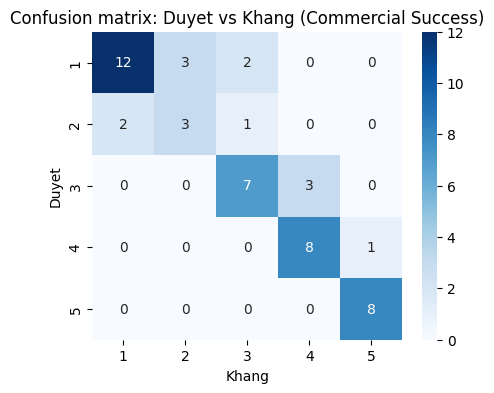

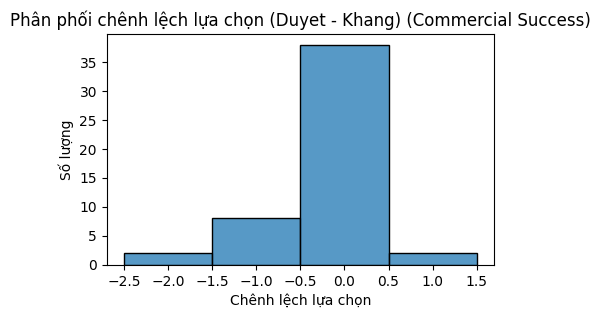

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 2
Vị trí các item bất đồng lớn nhất: [36, 47] 

Biểu đồ confusion giữa Duyet và Kiet:


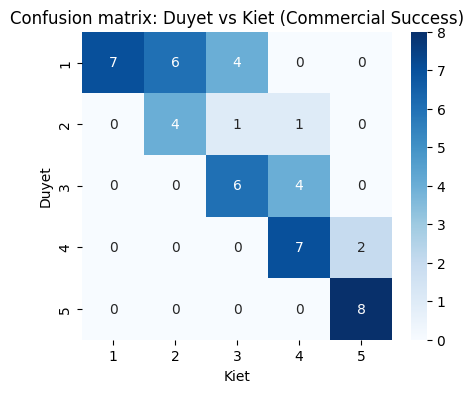

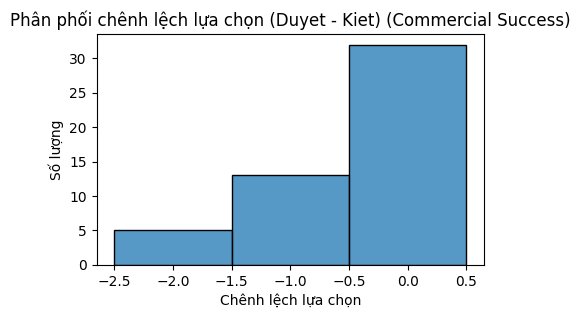

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 5
Vị trí các item bất đồng lớn nhất: [18, 19, 28, 39, 47] 

--- So sánh chi tiết giữa Duyet và các annotator cho trường: Public Success ---

Biểu đồ confusion giữa Duyet và Khang:


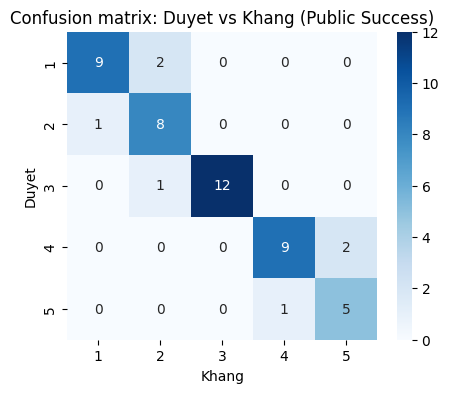

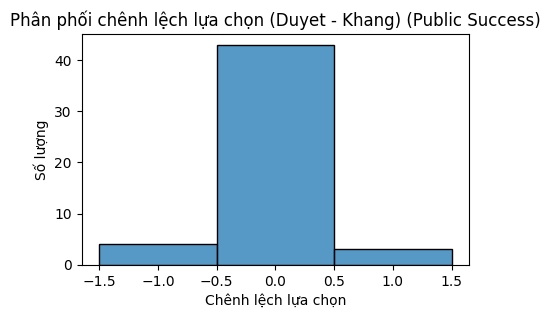

Số trường hợp bất đồng lớn nhất (|chênh lệch|=1): 7
Vị trí các item bất đồng lớn nhất: [7, 11, 17, 24, 40, 41, 43] 

Biểu đồ confusion giữa Duyet và Kiet:


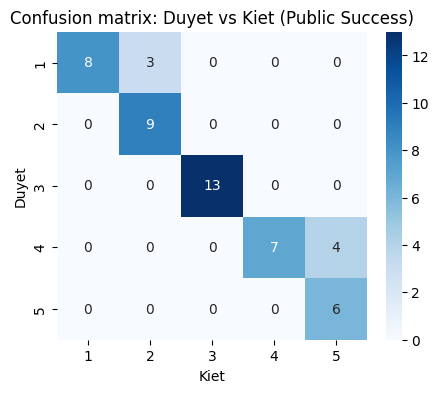

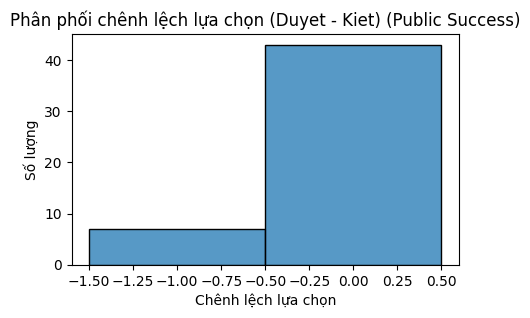

Số trường hợp bất đồng lớn nhất (|chênh lệch|=1): 7
Vị trí các item bất đồng lớn nhất: [7, 16, 18, 24, 33, 40, 41] 

--- So sánh chi tiết giữa Duyet và các annotator cho trường: Critical Success ---

Biểu đồ confusion giữa Duyet và Khang:


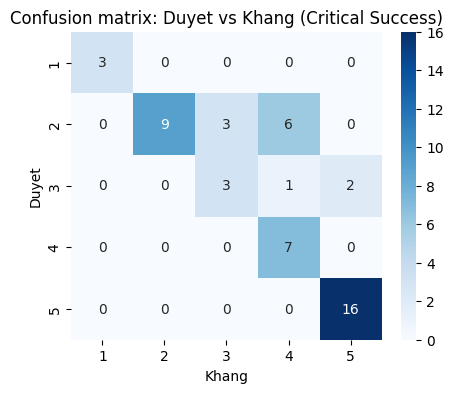

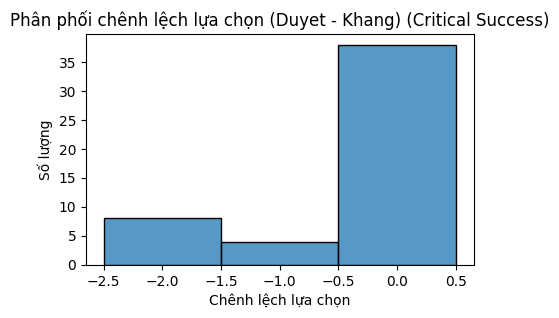

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 8
Vị trí các item bất đồng lớn nhất: [26, 32, 37, 39, 40, 46, 47, 48] 

Biểu đồ confusion giữa Duyet và Kiet:


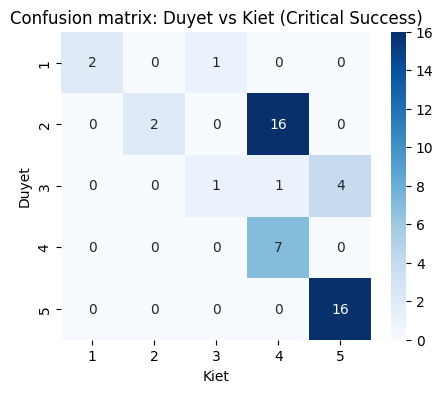

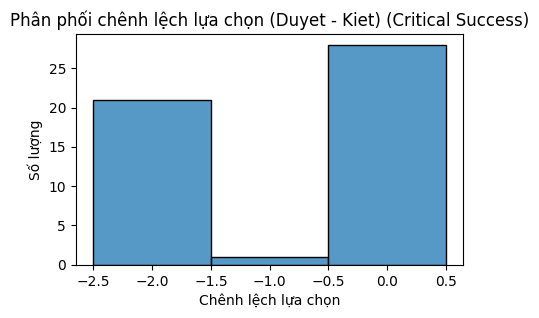

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 21
Vị trí các item bất đồng lớn nhất: [6, 7, 11, 12, 15, 16, 22, 23, 26, 29] ...



In [11]:
for field in fields:
    print(f"--- So sánh chi tiết giữa Duyet và các annotator cho trường: {field} Success ---")
    cols = [f'{ann}_{field}' for ann in annotators]
    
    for other in ['Khang', 'Kiet']:
        col1 = f'Duyet_{field}'
        col2 = f'{other}_{field}'
        mask = df[col1].notna() & df[col2].notna()
        c1_valid = df.loc[mask, col1].astype(str)
        c2_valid = df.loc[mask, col2].astype(str)
        
        print(f"\nBiểu đồ confusion giữa Duyet và {other}:")
        cm = pd.crosstab(c1_valid, c2_valid, rownames=['Duyet'], colnames=[other])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion matrix: Duyet vs {other} ({field} Success)')
        plt.show()
        
        diff = c1_valid.astype(int) - c2_valid.astype(int)
        plt.figure(figsize=(5,3))
        sns.histplot(diff, bins=np.arange(diff.min()-0.5, diff.max()+1.5), kde=False)
        plt.title(f'Phân phối chênh lệch lựa chọn (Duyet - {other}) ({field} Success)')
        plt.xlabel('Chênh lệch lựa chọn')
        plt.ylabel('Số lượng')
        plt.show()
        
        abs_diff = np.abs(diff)
        max_diff = abs_diff.max() if len(abs_diff) > 0 else 0
        idxs = np.where(abs_diff == max_diff)[0]
        print(f"Số trường hợp bất đồng lớn nhất (|chênh lệch|={max_diff}): {len(idxs)}")
        if len(idxs) > 0:
            print("Vị trí các item bất đồng lớn nhất:", idxs[:10].tolist(), "..." if len(idxs) > 10 else "")
    print()